In [60]:
import scipy.io
import numpy as np
import sys 
sys.path.append('../')
import math
import matplotlib.pyplot as plt
import opal as Opal
from scipy.spatial.transform import Rotation as R

In [61]:
# import test data from thigh and shank to calculate knee angles 
shank_data = np.loadtxt("DataShank.txt", delimiter=',')
thigh_data = np.loadtxt("DataThigh.txt", delimiter=',')


In [62]:
print(shank_data[:,3:6].shape)

(10001L, 3L)


In [63]:
def EKF(gyro, accl, dt):

    # Initialization
    n, m = gyro.shape
    X_all = np.zeros((n, 4))                                    # quaternion state
    P_all = np.zeros((4, 4, n))                                 # error covariance matrix
    bias_w = np.array([0, 0, 0])                                # gyroscope bias   
    bias_a = np.array([0, 0, 0])                                # accelerometer bias
    noise_w = 0.002 ** 2                                        # gyroscope error variance
    noise_a = 0.02 ** 2                                         # accelerometer error variance
    gc = 9.80665                                                # gravity magnitude, m/s^2

    initX = np.array([math.cos(np.pi/4), math.sin(np.pi/4), 0, 0])                              # can change to better initial prediction
    initP = np.eye(4) * 1e-4                                    # can change to better initial prediction
    X_all[0,:] = initX
    P_all[:,:,0] = initP
    x = initX
    P = initP

    for i in range(1, n):
        # ========= Predict -- gyroscope propagation ========= 
        w = gyro[i, :] - bias_w

        omega = np.array([[0, -w[0], -w[1], -w[2]], 
                          [w[0], 0, w[2], -w[1]],
                          [w[1], -w[2], 0, w[0]],
                          [w[2], w[1], -w[0], 0]])              
        FD = np.eye(4) + dt * omega / 2                    # propagation dynamics

        C = np.array([[-x[1], -x[2], -x[3]],
                      [x[0], -x[3], x[2]],
                      [x[3], x[0], -x[1]],
                      [-x[2], x[1], x[0]]]) / 2
        Q = (dt ** 2) * np.matmul(np.matmul(C, (noise_w * np.eye(3))), C.T)      # process noise matrix

        # Propagate the state and covariance
        x = np.matmul(FD, x)
        x = x / np.linalg.norm(x)                                      # normalize
        P = np.matmul(np.matmul(FD, P), FD.T) + Q 

        # ========= Measurement Update ========= 
        a = accl[i, :] - bias_a
        a = a.reshape(3,1)

        # Use non-linear equation to estimate prediction
        a_pred = gc * np.array([[2*(x[1]*x[3] - x[0]*x[2])], 
                                [2*(x[2]*x[3] + x[0]*x[1])], 
                                [x[0]**2 - x[1]**2 - x[2]**2 + x[3]**2]])
        
        H = 2 * gc * np.array([[-x[2], x[3], -x[0], x[1]],
                                [x[1], x[0], x[3], x[2]],
                                [x[0], -x[1], -x[2], x[3]]])     # measurement matrix

        # Measurement noise R is appropriate when the acceleration magnitude is approximately equal to gravity
        check = abs(np.linalg.norm(a) - gc)
        epsilon = 0.05                                          # tolerance

        if check < epsilon:
            R = np.eye(3) * noise_a
        else:
            R = np.eye(3) * 100

        # ========= Kalman Update ========= 
        K = np.matmul(np.matmul(P, H.T), np.linalg.inv(np.matmul(np.matmul(H, P), H.T) + R))
        x = x + np.matmul(K, (a - a_pred)).reshape(4,)
        x = x / np.linalg.norm(x)                                      # normalize
        P = np.matmul((np.eye(4) - np.matmul(K, H)), P)

        #  ========= Append to variables ========= 
        X_all[i, :] = x
        P_all[:, :, i] = P
    
    return X_all, P_all

In [64]:
def quat2euler(quat_mat):
    # w = quat_mat[:,0]
    # x = quat_mat[:,1]
    # y = quat_mat[:,2]
    # z = quat_mat[:,3]

    # t0 = 2.0 * (w*x + y*z)
    # t1 = 1.0 - 2.0 * (x*x + y*y)
    # rot_x = np.arctan2(t0, t1)

    # t2 = 2.0 * (w*y - z*x)
    # t2[t2 > 1.0] = 1.0                                          # enforce max and min values of 1.0 and -1.0
    # t2[t2 < -1.0] = 1.0
    # rot_y = np.arctan2(t2)

    # t3 = 2.0 * (w*z + x*y)
    # t4 = 1.0 - 2.0 * (y*y + z*z)
    # rot_z = np.arctan2(t3, t4)

    # eul_mat = np.hstack((rot_x, rot_y, rot_z))
    quat_wlast = np.hstack([quat_mat[:, 1:], quat_mat[:, 0].reshape(-1, 1)])
    r = R.from_quat(quat_wlast)
    return r.as_euler('xyz', degrees=True)

def rad2deg(rad):
    return rad * 180.0 / np.pi

In [65]:
X_shank, P_shank = EKF(shank_data[:,3:6], shank_data[:,0:3], 1e-3)
X_thigh, P_thigh = EKF(thigh_data[:,3:6], thigh_data[:,0:3], 1e-3)
eul_shank = quat2euler(X_shank)
eul_thigh = quat2euler(X_thigh)
# deg_shank = rad2deg(eul_shank)
# deg_thigh = rad2deg(eul_thigh)

In [69]:
X_thigh

array([[ 7.07106781e-01,  7.07106781e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 7.07151960e-01,  7.07061599e-01, -5.17338837e-06,
         3.37986073e-05],
       [ 7.07196574e-01,  7.07016974e-01, -1.10465811e-05,
         6.67941925e-05],
       ...,
       [ 8.24262941e-01,  5.55270839e-01, -8.38663647e-02,
        -7.23279496e-02],
       [ 8.23908679e-01,  5.55605882e-01, -8.46002167e-02,
        -7.29341919e-02],
       [ 8.23553770e-01,  5.55944731e-01, -8.53077503e-02,
        -7.35338781e-02]])

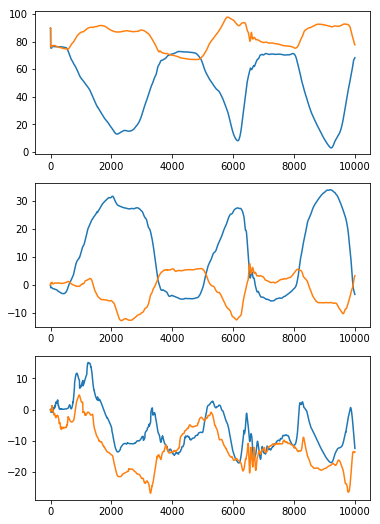

In [67]:
n, m = shank_data.shape

plt.figure(figsize=(6,9))
plt.subplot(311)
plt.plot(np.arange(0,n), eul_thigh[:,0])
plt.plot(np.arange(0,n), eul_shank[:,0])
# plt.axis([0, n, -30, 100])

plt.subplot(312)
plt.plot(np.arange(0,n), eul_thigh[:,1])
plt.plot(np.arange(0,n), eul_shank[:,1])
# plt.axis([0, n, -30, 30])

plt.subplot(313)
plt.plot(np.arange(0,n), eul_thigh[:,2])
plt.plot(np.arange(0,n), eul_shank[:,2])
# plt.axis([0, n, -30, 30])